In [106]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', None)
# import the required classes and definitions from Python-MIP
from mip import Model, xsum, maximize, BINARY, INTEGER

In [137]:
raw = pd.read_csv('top500histories', index_col=0)
top500_raw = pd.read_csv('top500.csv')

In [138]:
raw.columns

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'id_', 'web_name', 'gameweek', 'team',
       'sum_minutes', 'sum_points', 'next_week_points', 'team_a_conceded_rank',
       'team_a_conceded_rank_next', 'points_per_90'],
      dtype='object')

In [139]:
 df = top500_raw[['id_', 'web_name', 'team', 'element_type', 'assists', 'bonus', 'bps', 'clean_sheets', 
                 'goals_scored', 'minutes', 'saves', 'total_points',
                 'transfers_in', 'transfers_out']]

In [140]:
histories = raw[['id_', 'web_name', 'value', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'gameweek', 'saves', 'selected', 'total_points',
                 'team_a_score', 'team_h_score', 'transfers_in',
                 'transfers_out', 'sum_points', 'sum_minutes', 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'points_per_90', 'next_week_points']]

In [141]:
for gameweek in range(1, max(histories['gameweek'])): # + 1
    round_points = histories[histories['gameweek'] == gameweek][['id_', 'total_points']] 
    df = df.merge(round_points, on='id_', how='left', suffixes=('', '_' + str(gameweek)))
for gameweek in range(1, max(histories['gameweek'])): # + 1
    round_value = histories[histories['gameweek'] == gameweek][['id_', 'value']].rename(columns={'value':'value_' + str(gameweek)})
    df = df.merge(round_value, on='id_', how='left')
for gameweek in range(1, max(histories['gameweek'])): # + 1 
    round_minutes = histories[histories['gameweek'] == gameweek][['id_', 'minutes']].rename(columns={'minutes':'minutes_' + str(gameweek)})
    df = df.merge(round_minutes, on='id_', how='left')

In [142]:
df = df.fillna(0)

In [179]:
df

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,total_points_24,total_points_25,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,value_24,value_25,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25
0,191,Salah,10,3,6,21,474,14,14,1973,0,168,3269922,2914515,12,3,15.0,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,3.0,3.0,10.0,6.0,7.0,2.0,14.0,16.0,125,125,125.0,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,122.0,123.0,123.0,123.0,123.0,124.0,124.0,126.0,90,78,90.0,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,69.0,90.0,90.0,90.0,90.0,84.0,90.0,90.0
1,215,De Bruyne,11,3,17,20,662,10,7,1980,0,161,5005512,2548701,7,11,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2.0,7.0,2.0,95,1000,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107.0,107.0,107.0,78,90,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90.0,90.0,90.0
2,166,Vardy,9,4,6,25,565,8,17,2101,0,154,4136860,2358806,2,2,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0.0,1.0,2.0,90,90,89.0,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101.0,100.0,99.0,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90.0,42.0,79.0
3,182,Alexander-Arnold,10,2,12,15,661,11,2,2279,0,153,2613332,1225618,5,1,5.0,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,24.0,8.0,6.0,6.0,10.0,5.0,7.0,6.0,70,70,70.0,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,72.0,73.0,74.0,75.0,75.0,76.0,76.0,76.0,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90.0
4,192,Mané,10,3,8,18,443,9,12,1807,0,152,3662548,3387491,1,13,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,6.0,11.0,8.0,3.0,3.0,1.0,0.0,0.0,115,1000,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,122.0,122.0,123.0,123.0,124.0,124.0,124.0,123.0,16,90,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,90.0,90.0,77.0,80.0,82.0,32.0,0.0,0.0
5,313,Ings,16,4,1,28,488,2,15,1795,0,135,3045043,1054149,2,6,5.0,2.0,1.0,1.0,9.0,7.0,9.0,1.0,2.0,7.0,6.0,9.0,9.0,8.0,2.0,13.0,1.0,9.0,9.0,5.0,2.0,1.0,2.0,60,10000,60.0,60.0,60.0,60.0,59.0,59.0,59.0,59.0,60.0,60.0,60.0,61.0,62.0,63.0,64.0,64.0,65.0,66.0,66.0,67.0,69.0,70.0,70.0,65,26,83.0,76.0,16.0,13.0,82.0,80.0,90.0,45.0,83.0,90.0,72.0,90.0,76.0,87.0,90.0,86.0,21.0,90.0,75.0,90.0,90.0,20.0,69.0
6,233,Rashford,12,4,5,26,494,4,14,1876,0,134,2964666,3643672,13,0,0.0,2.0,9.0,2.0,4.0,2.0,9.0,9.0,2.0,5.0,11.0,5.0,13.0,9.0,2.0,2.0,6.0,9.0,2.0,12.0,0.0,0.0,0.0,85,86,87.0,86.0,85.0,85.0,84.0,84.0,84.0,84.0,85.0,85.0,86.0,87.0,87.0,88.0,90.0,91.0,91.0,91.0,91.0,92.0,91.0,90.0,89.0,85,88,90.0,90.0,90.0,60.0,90.0,90.0,83.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,62.0,90.0,90.0,58.0,0.0,0.0,0.0
7,183,van Dijk,10,2,0,11,572,12,4,2340,0,133,1614799,2096738,8,2,2.0,7.0,2.0,2.0,8.0,2.0,2.0,2.0,1.0,2

In [144]:
# position lists

keepers = list(df[df.element_type == 1].index)
defenders = list(df[df.element_type == 2].index)
midfielders = list(df[df.element_type == 3].index)
forwards = list(df[df.element_type == 4].index)

# team lists

ars = list(df[df.team == 1].index)
avl = list(df[df.team == 2].index)
bou = list(df[df.team == 3].index)
bha = list(df[df.team == 4].index)
bur = list(df[df.team == 5].index)
che = list(df[df.team == 6].index)
cry = list(df[df.team == 7].index)
eve = list(df[df.team == 8].index)
lei = list(df[df.team == 9].index)
liv = list(df[df.team == 10].index)
mci = list(df[df.team == 11].index)
mun = list(df[df.team == 12].index)
new = list(df[df.team == 13].index)
nor = list(df[df.team == 14].index)
shu = list(df[df.team == 15].index)
sou = list(df[df.team == 16].index)
tot = list(df[df.team == 17].index)
wat = list(df[df.team == 18].index)
whu = list(df[df.team == 19].index)
wol = list(df[df.team == 20].index)

In [145]:
# The selection models

def team_select(profit, weight, df):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = 830
    n = len(weight)

    #create an empty maximization
    m = Model('team_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 11.1
    m += xsum(df.element_type[i] * x[i] for i in keepers) >= 1 - .1
    m += xsum(df.element_type[i] * x[i] for i in keepers) <= 1 + .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) <= 10 + .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) <= 15 + .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) >= 4 - .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) <= 12 + .1

    # max 3 per team

    m += xsum(df.team[i] * x[i] for i in ars) <= 3
    m += xsum(df.team[i] * x[i] for i in avl) <= 6
    m += xsum(df.team[i] * x[i] for i in bou) <= 9
    m += xsum(df.team[i] * x[i] for i in bha) <= 12
    m += xsum(df.team[i] * x[i] for i in bur) <= 15
    m += xsum(df.team[i] * x[i] for i in che) <= 18
    m += xsum(df.team[i] * x[i] for i in cry) <= 21
    m += xsum(df.team[i] * x[i] for i in eve) <= 24
    m += xsum(df.team[i] * x[i] for i in lei) <= 27
    m += xsum(df.team[i] * x[i] for i in liv) <= 30
    m += xsum(df.team[i] * x[i] for i in mci) <= 33
    m += xsum(df.team[i] * x[i] for i in mun) <= 36
    m += xsum(df.team[i] * x[i] for i in new) <= 39
    m += xsum(df.team[i] * x[i] for i in nor) <= 42
    m += xsum(df.team[i] * x[i] for i in shu) <= 45
    m += xsum(df.team[i] * x[i] for i in sou) <= 48
    m += xsum(df.team[i] * x[i] for i in tot) <= 51
    m += xsum(df.team[i] * x[i] for i in wat) <= 54
    m += xsum(df.team[i] * x[i] for i in whu) <= 57
    m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    dream_team = df.iloc[selected,:].sort_values('element_type')
    return dream_team

In [176]:
def bench_select(profit, weight, formation, budget, data):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = budget
    n = len(weight)

    #create an empty maximization
    m = Model('bench_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 4.1
    m += xsum(data.element_type[i] * x[i] for i in keepers) >= .9
    m += xsum(data.element_type[i] * x[i] for i in keepers) <= 1.1
    m += xsum(data.element_type[i] * x[i] for i in defenders) >= 2 * formation[1] - .1
    m += xsum(data.element_type[i] * x[i] for i in defenders) <= 2 * formation[1] + .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) >= 3 * formation[2] - .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) <= 3 * formation[2] + .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) >= 4 * formation[3] - .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) <= 4 * formation[3] + .1

    # max 3 per team

#     m += xsum(df.team[i] * x[i] for i in ars) <= 3
#     m += xsum(df.team[i] * x[i] for i in avl) <= 6
#     m += xsum(df.team[i] * x[i] for i in bou) <= 9
#     m += xsum(df.team[i] * x[i] for i in bha) <= 12
#     m += xsum(df.team[i] * x[i] for i in bur) <= 15
#     m += xsum(df.team[i] * x[i] for i in che) <= 18
#     m += xsum(df.team[i] * x[i] for i in cry) <= 21
#     m += xsum(df.team[i] * x[i] for i in eve) <= 24
#     m += xsum(df.team[i] * x[i] for i in lei) <= 27
#     m += xsum(df.team[i] * x[i] for i in liv) <= 30
#     m += xsum(df.team[i] * x[i] for i in mci) <= 33
#     m += xsum(df.team[i] * x[i] for i in mun) <= 36
#     m += xsum(df.team[i] * x[i] for i in new) <= 39
#     m += xsum(df.team[i] * x[i] for i in nor) <= 42
#     m += xsum(df.team[i] * x[i] for i in shu) <= 45
#     m += xsum(df.team[i] * x[i] for i in sou) <= 48
#     m += xsum(df.team[i] * x[i] for i in tot) <= 51
#     m += xsum(df.team[i] * x[i] for i in wat) <= 54
#     m += xsum(df.team[i] * x[i] for i in whu) <= 57
#     m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    bench = data.iloc[selected,:].sort_values('element_type')
    return bench

In [164]:
mic = [91, 62, 52, 50, 74,
       71, 53, 50, 32, 77,
       85, 67, 86, 59, 50,
       71, 66, 43, 43, 58,
       61, 82, 42, 65, 54]

In [165]:
cooper = [83, 57, 57, 70, 58, 
          73, 52, 43, 32, 61, 
          74, 80, 58, 51, 55, 
          67, 65, 42, 28, 59, 
          54, 60, 45, 65, 60]

In [166]:
scout = [88, 65, 55, 64, 37, 
         90, 44, 36, 46, 51, 
         41, 87, 78, 56, 62, 
         65, 62, 28, 44, 53, 
         53, 58, 37, 77, 65]

In [167]:
global_ave = [65, 41, 44, 57, 52, 
              52, 51, 36, 37, 49,
              53, 48, 49, 51, 49,
              54, 56, 38, 49, 54,
              48, 57, 44, 53, 49]

In [168]:
top_10k_ave = [0.0, 0.0, 45.3, 54.5, 52.1,
             57.0, 50.8, 38.0, 35.9, 55.7,
             64.6, 65.5, 63.2, 50.3, 58.2,
             62.8, 61.6, 45.0, 53.0, 59.3,
             52.1, 60.1, 44.9, 62.9, 59.7]

In [169]:
team_points = pd.DataFrame({'scout':scout, 'mic':mic, 'cooper':cooper, 'top_10k':top_10k_ave, 'overall':global_ave})

In [170]:
team_points = team_points[:24]
team_points

,scout,mic,cooper,top_10k,overall
0,88,91,83,0.0,65
1,65,62,57,0.0,41
2,55,52,57,45.3,44
3,64,50,70,54.5,57
4,37,74,58,52.1,52
5,90,71,73,57.0,52
6,44,53,52,50.8,51
7,36,50,43,38.0,36
8,46,32,32,35.9,37
9,51,77,61,55.7,49


In [171]:
team_points['baseline'] = 0

In [172]:
team_points.head()

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0
1,65,62,57,0.0,41,0
2,55,52,57,45.3,44,0
3,64,50,70,54.5,57,0
4,37,74,58,52.1,52,0


In [173]:
number_of_alerts_baseline = 0
number_of_alerts_linear = 0
number_of_alerts_forest = 0

In [174]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,total_points_24,total_points_25,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,value_24,value_25,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25
0,191,Salah,10,3,6,21,474,14,14,1973,0,168,3269922,2914515,12,3,15.0,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,3.0,3.0,10.0,6.0,7.0,2.0,14.0,16.0,125,125,125.0,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,122.0,123.0,123.0,123.0,123.0,124.0,124.0,126.0,90,78,90.0,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,69.0,90.0,90.0,90.0,90.0,84.0,90.0,90.0
1,215,De Bruyne,11,3,17,20,662,10,7,1980,0,161,5005512,2548701,7,11,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2.0,7.0,2.0,95,1000,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107.0,107.0,107.0,78,90,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90.0,90.0,90.0
2,166,Vardy,9,4,6,25,565,8,17,2101,0,154,4136860,2358806,2,2,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0.0,1.0,2.0,90,90,89.0,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101.0,100.0,99.0,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90.0,42.0,79.0
3,182,Alexander-Arnold,10,2,12,15,661,11,2,2279,0,153,2613332,1225618,5,1,5.0,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,24.0,8.0,6.0,6.0,10.0,5.0,7.0,6.0,70,70,70.0,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,72.0,73.0,74.0,75.0,75.0,76.0,76.0,76.0,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90.0
4,192,Mané,10,3,8,18,443,9,12,1807,0,152,3662548,3387491,1,13,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,6.0,11.0,8.0,3.0,3.0,1.0,0.0,0.0,115,1000,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,122.0,122.0,123.0,123.0,124.0,124.0,124.0,123.0,16,90,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,90.0,90.0,77.0,80.0,82.0,32.0,0.0,0.0


In [180]:

for i in range(2, len(team_points.index) - 1):
    dream_team = team_select(df['total_points_'+ str(i)], df['value_'+ str(i)], df)
    next_week_points = dream_team['total_points_' + str(i + 1)]
    next_week_minutes = dream_team['minutes_' + str(i + 1)]
    print(dream_team[['total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'total_points_' + str(i)] = 0
#     print(bench_pool.head(40))


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    print(dream_team_formation)
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    print(bench_formation)
    bench = bench_select(bench_pool['total_points_' + str(i)],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['total_points_' + str(i)], ascending=False)
    print(bench_field[['total_points_' + str(i), 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])
    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    

    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)   

    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)
    
    bench_points = 0
    
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
                    dream_team_played_formation.loc[2] <= 5 and
                    dream_team_played_formation.loc[3] >= 2 and
                    dream_team_played_formation.loc[3] <= 5 and
                    dream_team_played_formation.loc[4] >= 1 and
                    dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_baseline = number_of_alerts_baseline + 1
    
    

    print('bench points: ', bench_points)

                
 
    
    captain = dream_team['total_points_' + str(i)].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points.baseline.loc[i] = final_points
    # adding the 'captain' points based on highest scoring player the previous week
   

     total_points_3       web_name  team  minutes_3
24              2.0           Pope     5       90.0
112             2.0          Kelly     7       90.0
236             1.0     Adam Smith     3       67.0
277             1.0   Kiko Femenía    18       90.0
426             1.0        Daniels     3       36.0
88              2.0        Norwood    15       90.0
262             3.0      Longstaff    13       90.0
295             2.0        Trybull    14       80.0
415             0.0         Gbamin     8        0.0
421             0.0     Smith Rowe     1        0.0
58              5.0  Callum Wilson     3       68.0
dream team cost:  540
bench budget:  460
1    1
2    4
3    5
4    1
Name: element_type, dtype: int64
[1, 1, 0, 2]


SolutionNotAvailable: Infeasible __model,                 solution not available.

In [128]:
team_points

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0
1,65,62,57,0.0,41,0
2,55,52,57,45.3,44,0
3,64,50,70,54.5,57,0
4,37,74,58,52.1,52,0
5,90,71,73,57.0,52,0
6,44,53,52,50.8,51,0
7,36,50,43,38.0,36,0
8,46,32,32,35.9,37,0
9,51,77,61,55.7,49,0


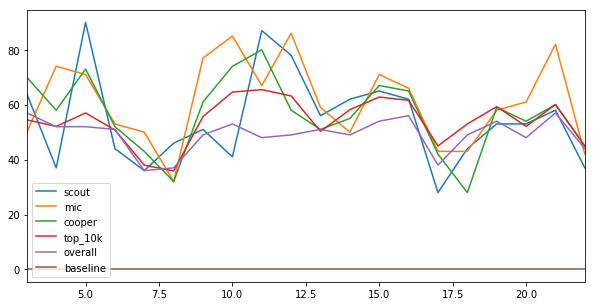

In [129]:
%matplotlib inline
team_points.loc[3:22].plot(figsize=(10,5))

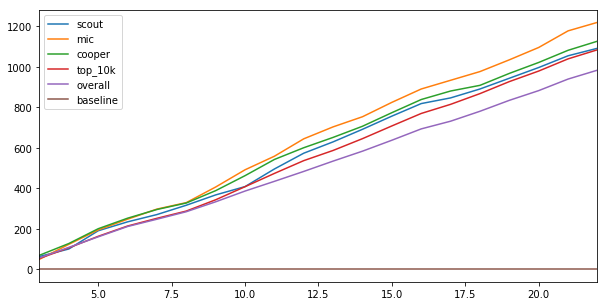

In [130]:
team_points.loc[3:22].cumsum().plot(figsize=(10,5))

In [131]:
team_points.loc[3:22].sum()

scout       1092.0
mic         1220.0
cooper      1127.0
top_10k     1084.6
overall      984.0
baseline       0.0
dtype: float64

In [132]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,total_points_24,total_points_25,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,value_24,value_25,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25
0,191,Salah,10,3,6,21,474,14,14,1973,0,168,3269922,2914515,12,3,15.0,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,3.0,3.0,10.0,6.0,7.0,2.0,14.0,16.0,125,125,125.0,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,122.0,123.0,123.0,123.0,123.0,124.0,124.0,126.0,90,78,90.0,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,69.0,90.0,90.0,90.0,90.0,84.0,90.0,90.0
1,215,De Bruyne,11,3,17,20,662,10,7,1980,0,161,5005512,2548701,7,11,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2.0,7.0,2.0,95,1000,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107.0,107.0,107.0,78,90,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90.0,90.0,90.0
2,166,Vardy,9,4,6,25,565,8,17,2101,0,154,4136860,2358806,2,2,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0.0,1.0,2.0,90,90,89.0,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101.0,100.0,99.0,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90.0,42.0,79.0
3,182,Alexander-Arnold,10,2,12,15,661,11,2,2279,0,153,2613332,1225618,5,1,5.0,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,24.0,8.0,6.0,6.0,10.0,5.0,7.0,6.0,70,70,70.0,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,72.0,73.0,74.0,75.0,75.0,76.0,76.0,76.0,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90.0
4,192,Mané,10,3,8,18,443,9,12,1807,0,152,3662548,3387491,1,13,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,6.0,11.0,8.0,3.0,3.0,1.0,0.0,0.0,115,1000,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,122.0,122.0,123.0,123.0,124.0,124.0,124.0,123.0,16,90,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,90.0,90.0,77.0,80.0,82.0,32.0,0.0,0.0


In [133]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,gameweek,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,191,Salah,125,1,2,40,0,1,90,1,0,2375465,12,1.0,4.0,0,0,12,90,16,17,12.000000,3
1,191,Salah,125,0,0,0,1,0,78,2,0,2778082,3,2.0,1.0,156910,42628,15,168,17,11,8.035714,15
2,191,Salah,125,0,3,43,0,2,90,3,0,2444065,15,1.0,3.0,47097,398638,30,258,11,7,10.465116,6
3,191,Salah,125,1,0,15,1,0,90,4,0,2810462,6,3.0,0.0,291554,48024,36,348,7,13,9.310345,9
4,191,Salah,125,0,2,34,0,1,90,5,0,2874525,9,1.0,3.0,124574,92676,45,438,13,18,9.246575,5


In [134]:
def linear_predict(gameweek, data):
    m = ols('next_week_points ~ goals_scored + assists + clean_sheets + saves + value + bps + selected + transfers_in + transfers_out + minutes + points_per_90',  data[data['gameweek'] <= gameweek - 1]).fit()
    next_week = data[data['gameweek'] == gameweek]
    predictions = m.predict(next_week)
    next_week['next_week_predictions'] = predictions   
    return next_week

In [135]:
team_points['linear_points'] = 0

In [181]:
for i in range(2, len(team_points.index) - 1):
    df_linear = linear_predict(i, histories)
    df_copy = df
    df_copy = df_copy.merge(df_linear[['id_', 'next_week_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.next_week_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
    
    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df_copy
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'next_week_predictions'] = 0


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['next_week_predictions'],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
    print(bench.web_name)
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['next_week_predictions'], ascending=False)
    print(bench_field[['next_week_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)  
    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)

    bench_points = 0
    
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
            dream_team_played_formation.loc[2] <= 5 and
            dream_team_played_formation.loc[3] >= 2 and
            dream_team_played_formation.loc[3] <= 5 and
            dream_team_played_formation.loc[4] >= 1 and
            dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_linear = number_of_alerts_linear + 1
    
    
    print('bench points: ', bench_points)
    
    
    
    
    
    
    captain = dream_team['next_week_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points['linear_points'].loc[i] = final_points

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_3     web_name  minutes_3
50              1.0     Ramsdale       90.0
25              7.0      Baldock       90.0
183             1.0         Burn       90.0
214             9.0       Engels       90.0
235             9.0  Vestergaard       90.0
322             6.0       Krafth       90.0
270             1.0       Alzate       90.0
302             1.0  Stiepermann       80.0
366             3.0         Duda       90.0
392             3.0         Rupp       88.0
431             0.0       Niasse        0.0
dream team cost:  515
bench budget:  485


SolutionNotAvailable: Infeasible __model,                 solution not available.

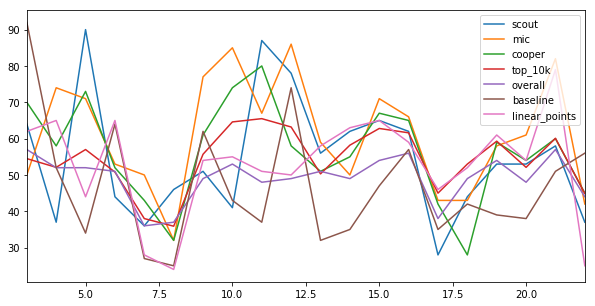

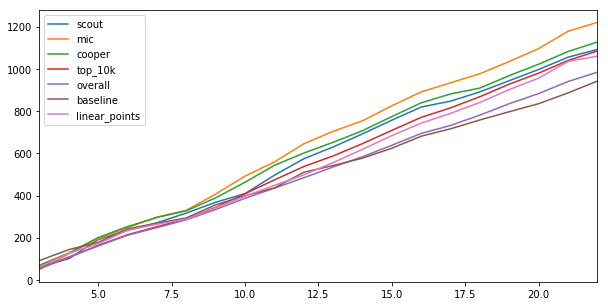

In [79]:
%matplotlib inline
team_points.loc[3:22].plot(figsize=(10,5))
team_points.loc[3:22].cumsum().plot(figsize=(10,5))

In [80]:
team_points.loc[3:22].sum()

scout            1092.0
mic              1220.0
cooper           1127.0
top_10k          1084.6
overall           984.0
baseline          942.0
linear_points    1060.0
dtype: float64

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
team_points.shape

(24, 7)

In [71]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5,0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2,2,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3,1,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0,4,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2,3,438722,38930,37,359,20,20,9.275766,17


In [72]:
df_forest = histories[['id_', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'gameweek', 'saves', 'selected', 
                 'total_points',
                 'transfers_in', 
                 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'transfers_out',
                 'points_per_90', 'next_week_points']].sort_values('gameweek')

In [73]:
df_forest.head()

,id_,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,transfers_in,team_a_conceded_rank,team_a_conceded_rank_next,transfers_out,points_per_90,next_week_points
0,215,1,1,37,1,0,78,1,0,868463,7,0,20,13,0,8.076923,11
2784,184,0,0,10,0,0,90,1,0,101038,2,0,16,17,0,2.000000,0
2808,68,0,0,6,0,0,90,1,0,1189451,2,0,10,17,0,2.000000,6
2832,65,0,0,13,0,0,90,1,0,281145,2,0,10,17,0,2.000000,0
9539,132,0,0,0,0,0,0,1,0,63901,0,0,1,2,0,0.000000,0


In [74]:
def forest_predict(gameweek):
    df_clean = df_forest.drop('id_', axis=1)
    df_clean = df_clean[df_clean['gameweek'] <= gameweek - 1]
    X_train = df_clean.drop('next_week_points', axis=1)
    y_train = df_clean.next_week_points
    rfr = RandomForestRegressor(n_estimators=275, max_depth=4, random_state=42)
    rfr.fit(X_train, y_train)
    next_week = df_forest[df_forest['gameweek'] == gameweek]
    X_test = next_week.drop(['id_', 'next_week_points'], axis=1)
    y_pred = rfr.predict(X_test)
    next_week['forest_predictions'] = y_pred
    return next_week
    
    
    

In [75]:
team_points['forest_points'] = 0

In [76]:
for i in range(2, len(team_points.index) - 1):
    df_forest_predictions = forest_predict(i)
    df_copy = df
    df_copy = df_copy.merge(df_forest_predictions[['id_', 'forest_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.forest_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df_copy
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'forest_predictions'] = 0


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['forest_predictions'],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
    print(bench.web_name)
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['forest_predictions'], ascending=False)
    print(bench_field[['forest_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)
    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)

    bench_points = 0
    
        
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
                    dream_team_played_formation.loc[2] <= 5 and
                    dream_team_played_formation.loc[3] >= 2 and
                    dream_team_played_formation.loc[3] <= 5 and
                    dream_team_played_formation.loc[4] >= 1 and
                    dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_forest = number_of_alerts_forest + 1

    
    print('bench points: ', bench_points)

    
    
    
    
    captain = dream_team['forest_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points['forest_points'].loc[i] = final_points

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_3     web_name  minutes_3
91              3.0      Ederson       90.0
63              1.0         Dunk       90.0
98              2.0        Kelly       90.0
159             0.0  Wan-Bissaka       90.0
33              5.0      Martial       90.0
93              2.0     Trossard       90.0
99              2.0  Lucas Moura       90.0
115             2.0        Neves       90.0
5               0.0     Rashford       90.0
8               5.0   Aubameyang       90.0
112             1.0    Lacazette        9.0
dream team cost:  758.0
bench budget:  242.0
81          de Gea
10        van Dijk
323    El Mohamady
123           Groß
Name: web_name, dtype: object
bench cost:  231.0
     forest_predictions  total_points_3     web_name  team  minutes_3
123            3.768940             1.0         Groß     4       12.0
323            3.270725             1.0  El Mohamady     2        4.0
10             3.252227             2.0     van Dijk    10       90.0
1    1
2    3
3    4
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_4    web_name  minutes_4
50              2.0    Patrício       90.0
10              7.0    van Dijk       90.0
12              6.0   Robertson       90.0
180             0.0      Alonso        0.0
14              3.0    Sterling       90.0
39              2.0       Mount       90.0
139             5.0  Sigurdsson       90.0
372             0.0       Pedro        0.0
1              16.0       Vardy       90.0
6               5.0     Jiménez       90.0
13              2.0       Pukki       90.0
dream team cost:  812.0
bench budget:  188.0
53          Leno
19     Lundstram
138          Aké
37      Cantwell
Name: web_name, dtype: object
bench cost:  187.0
     forest_predictions  total_points_4   web_name  team  minutes_4
37             3.725183             2.0   Cantwell    14       77.0
138            3.178253             1.0        Aké     3       90.0
19             2.873546             1.0  Lundstram    15       90.0
1    1
2    2
3    3
4    3
dtype: int64
num of be

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_5        web_name  minutes_5
91              1.0         Ederson       90.0
10              2.0        van Dijk       90.0
12              5.0       Robertson       90.0
111             1.0          Walker       90.0
159             6.0     Wan-Bissaka       90.0
3              15.0            Mané       90.0
73              4.0  Bernardo Silva       72.0
139             2.0      Sigurdsson       70.0
6               2.0         Jiménez       69.0
8              13.0      Aubameyang       90.0
44              1.0            Ayew       70.0
dream team cost:  817.0
bench budget:  183.0
43           Ryan
98          Kelly
72       Jorginho
108    Dendoncker
Name: web_name, dtype: object
bench cost:  182.0
     forest_predictions  total_points_5    web_name  team  minutes_5
98             3.913871             0.0       Kelly     7        0.0
108            3.701519             1.0  Dendoncker    20       45.0
72             3.377393             5.0    Jorginho     6      

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_6     web_name  minutes_6
81              2.0       de Gea       90.0
10              2.0     van Dijk       90.0
12              8.0    Robertson       90.0
159             1.0  Wan-Bissaka       90.0
2               5.0        Salah       90.0
14              0.0     Sterling        0.0
37              2.0     Cantwell       89.0
39              2.0        Mount       90.0
5               2.0     Rashford       60.0
13              2.0        Pukki       90.0
117             2.0         King       90.0
dream team cost:  823.0
bench budget:  177.0
428          Randolph
19          Lundstram
132           Maguire
73     Bernardo Silva
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_6        web_name  team  minutes_6
73             5.043303            19.0  Bernardo Silva    11       90.0
132            4.729301             1.0         Maguire    12       90.0
19             2.927707            12.0       Lundstram    15       90.

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_7          web_name  minutes_7
91              4.0           Ederson       90.0
4               6.0  Alexander-Arnold       90.0
10              8.0          van Dijk       90.0
111             2.0            Walker       90.0
2               3.0             Salah       90.0
37              2.0          Cantwell       80.0
39              6.0             Mount       90.0
42              1.0       David Silva        4.0
7               2.0           Abraham       83.0
13              2.0             Pukki       90.0
22              8.0              Kane       90.0
dream team cost:  825.0
bench budget:  175.0
48       Ramsdale
118          Rico
205         Saïss
108    Dendoncker
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_7    web_name  team  minutes_7
108            3.477078             3.0  Dendoncker    20       90.0
205            2.821681             6.0       Saïss    20       90.0
118            2.713510             0.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_8    web_name  minutes_8
24              6.0   Henderson       90.0
10              2.0    van Dijk       90.0
19              5.0   Lundstram       90.0
247             6.0      Engels       74.0
2               2.0       Salah       90.0
14              2.0    Sterling       90.0
39              7.0       Mount       79.0
107             1.0      McGinn       90.0
7               8.0     Abraham       83.0
8               2.0  Aubameyang       90.0
13              1.0       Pukki       83.0
dream team cost:  825.0
bench budget:  175.0
114     Heaton
26     Baldock
98       Kelly
268    Nakamba
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_8 web_name  team  minutes_8
268            4.020336             2.0  Nakamba     2       90.0
26             3.887965             6.0  Baldock    15       90.0
98             3.405309             7.0    Kelly     7       90.0
1    1
2    3
3    4
4    3
dtype: int64
num of benched:  0
bench 

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_9    web_name  minutes_9
48              6.0    Ramsdale       90.0
118             8.0        Rico       90.0
176             2.0  Vertonghen       90.0
192             9.0  Steve Cook       90.0
2               0.0       Salah        0.0
25              1.0         Son       45.0
37              3.0    Cantwell       80.0
172             1.0     Sissoko       90.0
7               2.0     Abraham       90.0
11              0.0      Agüero        0.0
13              1.0       Pukki       90.0
dream team cost:  782.0
bench budget:  218.0
128       Gazzaniga
152    Alderweireld
306          Stacey
204         Billing
Name: web_name, dtype: object
bench cost:  193.0
     forest_predictions  total_points_9      web_name  team  minutes_9
204            4.468723             3.0       Billing     3       90.0
306            4.371000             0.0        Stacey     3        0.0
152            4.346631             2.0  Alderweireld    17       90.0
1    1
2    3
3    3
4    

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_10        web_name  minutes_10
81               2.0          de Gea        90.0
21               6.0         Pereira        90.0
38               6.0           Evans        90.0
47               6.0         Söyüncü        90.0
57              -1.0           Digne        90.0
159              1.0     Wan-Bissaka        90.0
0                6.0       De Bruyne        75.0
68               6.0           James        79.0
73               3.0  Bernardo Silva        90.0
13               2.0           Pukki        90.0
22               7.0            Kane        90.0
dream team cost:  748.0
bench budget:  252.0
35     Schmeichel
17       Maddison
102         Ndidi
7         Abraham
Name: web_name, dtype: object
bench cost:  250.0
     forest_predictions  total_points_10  web_name  team  minutes_10
17             3.996315              8.0  Maddison     9        90.0
102            3.961172              3.0     Ndidi     9        90.0
7              3.816399              5.

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_11          web_name  minutes_11
43              6.0              Ryan        90.0
4               7.0  Alexander-Arnold        90.0
10              1.0          van Dijk        90.0
63              7.0              Dunk        90.0
0               2.0         De Bruyne        90.0
2               2.0             Salah        64.0
42              1.0       David Silva        45.0
73              2.0    Bernardo Silva        83.0
7              12.0           Abraham        87.0
13              2.0             Pukki        90.0
41              2.0            Maupay        90.0
dream team cost:  818.0
bench budget:  182.0
91      Ederson
230       Mendy
390    Tanganga
185    Gündogan
Name: web_name, dtype: object
bench cost:  172.0
     forest_predictions  total_points_11  web_name  team  minutes_11
230            5.290670              0.0     Mendy    11         0.0
185            5.269102              1.0  Gündogan    11        90.0
390            0.000000            

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_12     web_name  minutes_12
50               3.0     Patrício        90.0
57               2.0        Digne        90.0
64               6.0     Chilwell        90.0
157              2.0         Mina        90.0
0                2.0    De Bruyne        90.0
17               9.0     Maddison        90.0
18              10.0  Richarlison        88.0
108              2.0   Dendoncker        90.0
1               12.0        Vardy        90.0
11               2.0       Agüero        70.0
13               2.0        Pukki        90.0
dream team cost:  802.0
bench budget:  198.0
71        Pickford
118           Rico
232        Janmaat
364    André Gomes
Name: web_name, dtype: object
bench cost:  194.0
     forest_predictions  total_points_12     web_name  team  minutes_12
364            3.665047              0.0  André Gomes     8         0.0
232            3.593876              7.0      Janmaat    18        90.0
118            3.578862              1.0         Rico     3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_13     web_name  minutes_13
71               2.0     Pickford        90.0
19               3.0    Lundstram        90.0
57               1.0        Digne        90.0
150              1.0   David Luiz        90.0
3                9.0         Mané        90.0
18               2.0  Richarlison        90.0
39               1.0        Mount        16.0
210              1.0    Guendouzi        90.0
8                5.0   Aubameyang        90.0
13               5.0        Pukki        90.0
22               6.0         Kane        90.0
dream team cost:  821.0
bench budget:  179.0
28             Pope
170         Holgate
201        Chambers
352    Schneiderlin
Name: web_name, dtype: object
bench cost:  179.0
     forest_predictions  total_points_13      web_name  team  minutes_13
201            4.022710              1.0      Chambers     1        45.0
352            3.640811              0.0  Schneiderlin     8        55.0
170            3.421062              0.0       Holgate 

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_14    web_name  minutes_14
29              2.0      Foster        90.0
12              2.0   Robertson        90.0
21              7.0     Pereira        90.0
47              2.0     Söyüncü        90.0
0              10.0   De Bruyne        90.0
3               2.0        Mané        90.0
37              8.0    Cantwell        82.0
83              2.0     Pulisic        90.0
7               0.0     Abraham         0.0
8              13.0  Aubameyang        90.0
62              2.0    Deulofeu        66.0
dream team cost:  825.0
bench budget:  175.0
28           Pope
94       Cathcart
276      Williams
108    Dendoncker
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_14    web_name  team  minutes_14
94             3.283930              1.0    Cathcart    18        90.0
108            3.100579              1.0  Dendoncker    20        90.0
276            2.830073              0.0    Williams    12        78.0
1    1
2    3
3    4
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_15   web_name  minutes_15
43              3.0       Ryan        90.0
19              1.0  Lundstram        90.0
21              7.0    Pereira        90.0
98              6.0      Kelly        90.0
2               0.0      Salah         0.0
3              15.0       Mané        90.0
17             10.0   Maddison        90.0
37              2.0   Cantwell        82.0
1               5.0      Vardy        90.0
6               2.0    Jiménez        83.0
13              8.0      Pukki        90.0
dream team cost:  808.0
bench budget:  192.0
92          Krul
47       Söyüncü
63          Dunk
210    Guendouzi
Name: web_name, dtype: object
bench cost:  187.0
     forest_predictions  total_points_15   web_name  team  minutes_15
47             3.932902              5.0    Söyüncü     9        90.0
63             3.805481              2.0       Dunk     4        90.0
210            3.610771              0.0  Guendouzi     1         0.0
1    1
2    3
3    3
4    3
dtype: int64
n

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_16          web_name  minutes_16
35              2.0        Schmeichel        90.0
4               1.0  Alexander-Arnold        50.0
19              2.0         Lundstram        90.0
21              1.0           Pereira        90.0
98              8.0             Kelly        90.0
25             12.0               Son        90.0
39              2.0             Mount        90.0
83              2.0           Pulisic        90.0
1              13.0             Vardy        90.0
7               2.0           Abraham        90.0
8              12.0        Aubameyang        90.0
dream team cost:  806.0
bench budget:  194.0
50     Patrício
47      Söyüncü
37     Cantwell
151      Hayden
Name: web_name, dtype: object
bench cost:  192.0
     forest_predictions  total_points_16  web_name  team  minutes_16
47             3.926987              2.0   Söyüncü     9        90.0
151            3.520582              2.0    Hayden    13        90.0
37             3.423748            

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_17   web_name  minutes_17
24              6.0  Henderson        90.0
10              7.0   van Dijk        90.0
19             11.0  Lundstram        90.0
47              3.0    Söyüncü        90.0
98              2.0      Kelly        90.0
0              19.0  De Bruyne        90.0
3               6.0       Mané        90.0
17              2.0   Maddison        90.0
1               5.0      Vardy        90.0
5               2.0   Rashford        90.0
7               2.0    Abraham        90.0
dream team cost:  825.0
bench budget:  175.0
320        Martin
97        Willems
108    Dendoncker
151        Hayden
Name: web_name, dtype: object
bench cost:  174.0
     forest_predictions  total_points_17    web_name  team  minutes_17
97             3.307491              2.0     Willems    13        70.0
108            3.255372              1.0  Dendoncker    20        90.0
151            2.878994              2.0      Hayden    13        90.0
1    1
2    4
3    3
4    3
dtype:

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_18     web_name  minutes_18
50               4.0     Patrício        90.0
98               2.0        Kelly        90.0
118              1.0         Rico        90.0
159              1.0  Wan-Bissaka        90.0
3                0.0         Mané         0.0
25              -1.0          Son        61.0
39               3.0        Mount        90.0
68               1.0        James        57.0
5                2.0     Rashford        90.0
6                7.0      Jiménez        90.0
7                2.0      Abraham        79.0
dream team cost:  786.0
bench budget:  214.0
81       de Gea
47      Söyüncü
132     Maguire
51     Moutinho
Name: web_name, dtype: object
bench cost:  213.0
     forest_predictions  total_points_18  web_name  team  minutes_18
132            3.740003              1.0   Maguire    12        90.0
51             3.653977              4.0  Moutinho    20        90.0
47             3.489738              0.0   Söyüncü     9        90.0
1    1
2    3


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_19   web_name  minutes_19
114             10.0     Heaton        90.0
19               2.0  Lundstram        90.0
26               6.0    Baldock        90.0
98               2.0      Kelly        90.0
0                5.0  De Bruyne        66.0
14              10.0   Sterling        90.0
20               6.0   Grealish        90.0
39               1.0      Mount        45.0
5                6.0   Rashford        62.0
7                2.0    Abraham        90.0
13               1.0      Pukki        90.0
dream team cost:  774.0
bench budget:  226.0
43         Ryan
47      Söyüncü
59    O'Connell
17     Maddison
Name: web_name, dtype: object
bench cost:  223.0
    forest_predictions  total_points_19   web_name  team  minutes_19
17            3.994211              1.0   Maddison     9        75.0
47            3.484176              0.0    Söyüncü     9        90.0
59            3.405806              2.0  O'Connell    15        90.0
1    1
2    3
3    4
4    3
dtype: int

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_20   web_name  minutes_20
45              3.0     Guaita        90.0
10              6.0   van Dijk        90.0
19              0.0  Lundstram         0.0
98              2.0      Kelly        90.0
3              11.0       Mané        90.0
17              1.0   Maddison        26.0
32              2.0       Alli        90.0
37              1.0   Cantwell         4.0
1               0.0      Vardy         0.0
5               9.0   Rashford        90.0
7               7.0    Abraham        90.0
dream team cost:  819.0
bench budget:  181.0
128       Gazzaniga
84           Aurier
424         Simpson
96     Douglas Luiz
Name: web_name, dtype: object
bench cost:  180.0
     forest_predictions  total_points_20      web_name  team  minutes_20
84             3.788330             -1.0        Aurier    17        90.0
424            3.155594              0.0       Simpson     3         0.0
96             3.051653              2.0  Douglas Luiz     2        90.0
1    1
2    2
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_21   web_name  minutes_21
45              3.0     Guaita        90.0
10              7.0   van Dijk        90.0
12             12.0  Robertson        87.0
19              1.0  Lundstram        90.0
98              2.0      Kelly        82.0
17             11.0   Maddison        76.0
32              2.0       Alli        90.0
39              3.0      Mount        72.0
1               0.0      Vardy         0.0
5               2.0   Rashford        90.0
22              2.0       Kane        74.0
dream team cost:  813.0
bench budget:  187.0
114          Heaton
127         Targett
27           Traoré
96     Douglas Luiz
Name: web_name, dtype: object
bench cost:  187.0
     forest_predictions  total_points_21      web_name  team  minutes_21
96             3.354462              7.0  Douglas Luiz     2        90.0
127            3.190312              0.0       Targett     2         0.0
27             3.087219              2.0        Traoré    20        90.0
1    1
2    4
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_22          web_name  minutes_22
35              4.0        Schmeichel        90.0
4               6.0  Alexander-Arnold        90.0
47              1.0           Söyüncü        90.0
98              2.0             Kelly        90.0
0               9.0         De Bruyne        62.0
3               3.0              Mané        80.0
17              2.0          Maddison        90.0
37              2.0          Cantwell        90.0
5              12.0          Rashford        58.0
6               2.0           Jiménez        90.0
7               6.0           Abraham        90.0
dream team cost:  821.0
bench budget:  179.0
428     Randolph
10      van Dijk
19     Lundstram
39         Mount
Name: web_name, dtype: object
bench cost:  179.0
    forest_predictions  total_points_22   web_name  team  minutes_22
10            4.428301              6.0   van Dijk    10        90.0
39            4.347493              3.0      Mount     6        90.0
19            4.007600         

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_23          web_name  minutes_23
43                2              Ryan          90
4                10  Alexander-Arnold          90
10               15          van Dijk          90
19                2         Lundstram          66
0                 2         De Bruyne          90
14                2          Sterling          88
17                2          Maddison          90
37                3          Cantwell          90
1                 0             Vardy          90
6                13           Jiménez          90
9                 2              Ings          90
dream team cost:  830.0
bench budget:  170.0
320        Martin
98          Kelly
397        Hanley
108    Dendoncker
Name: web_name, dtype: object
bench cost:  169.0
     forest_predictions  total_points_23    web_name  team  minutes_23
98             4.090241                1       Kelly     7          90
108            3.690321                2  Dendoncker    20          90
397            2.8841

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [77]:
team_points

,scout,mic,cooper,top_10k,overall,baseline,linear_points,forest_points
0,88,91,83,0.0,65,0.0,0.0,0.0
1,65,62,57,0.0,41,0.0,0.0,0.0
2,55,52,57,45.3,44,40.0,51.0,24.0
3,64,50,70,54.5,57,92.0,55.0,51.0
4,37,74,58,52.1,52,52.0,61.0,65.0
5,90,71,73,57.0,52,38.0,46.0,49.0
6,44,53,52,50.8,51,64.0,65.0,46.0
7,36,50,43,38.0,36,28.0,28.0,50.0
8,46,32,32,35.9,37,25.0,24.0,37.0
9,51,77,61,55.7,49,57.0,60.0,50.0


scout            1092.0
mic              1220.0
cooper           1127.0
top_10k          1084.6
overall           984.0
baseline          925.0
linear_points    1042.0
forest_points    1030.0
dtype: float64

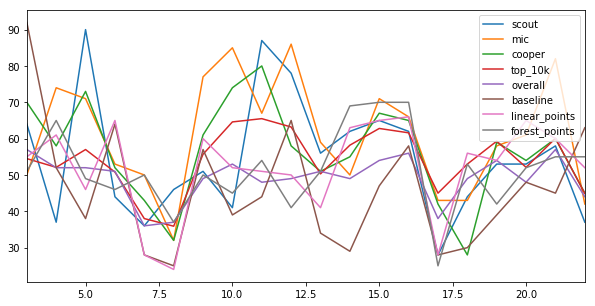

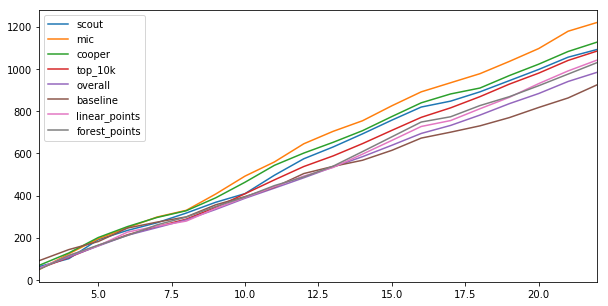

In [78]:
team_points.loc[3:22].plot(figsize=(10,5))
team_points.loc[3:22].cumsum().plot(figsize=(10,5))
team_points.loc[3:22].sum()

In [79]:
print('number of times missing bench points baseline:', number_of_alerts_baseline)
print('number of times missing bench points linear:', number_of_alerts_forest)
print('number of times missing bench points forest:', number_of_alerts_forest)

number of times missing bench points baseline: 2
number of times missing bench points linear: 2
number of times missing bench points forest: 2


In [80]:
import seaborn as sns

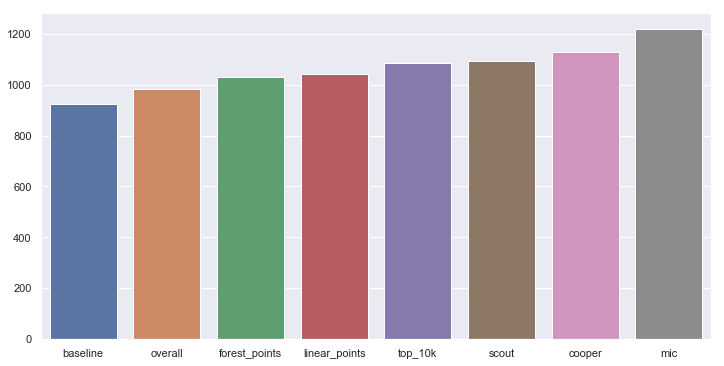

In [81]:
sums = team_points.loc[3:22].sum().sort_values()
sns.set(rc={'figure.figsize':(12, 6)})
sns.barplot(x = sums.index, y = sums)